In [1]:
!pip install tensorflow
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import random
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, Flatten , GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.models import Sequential, Model


In [43]:
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50 , VGG16 , InceptionV3


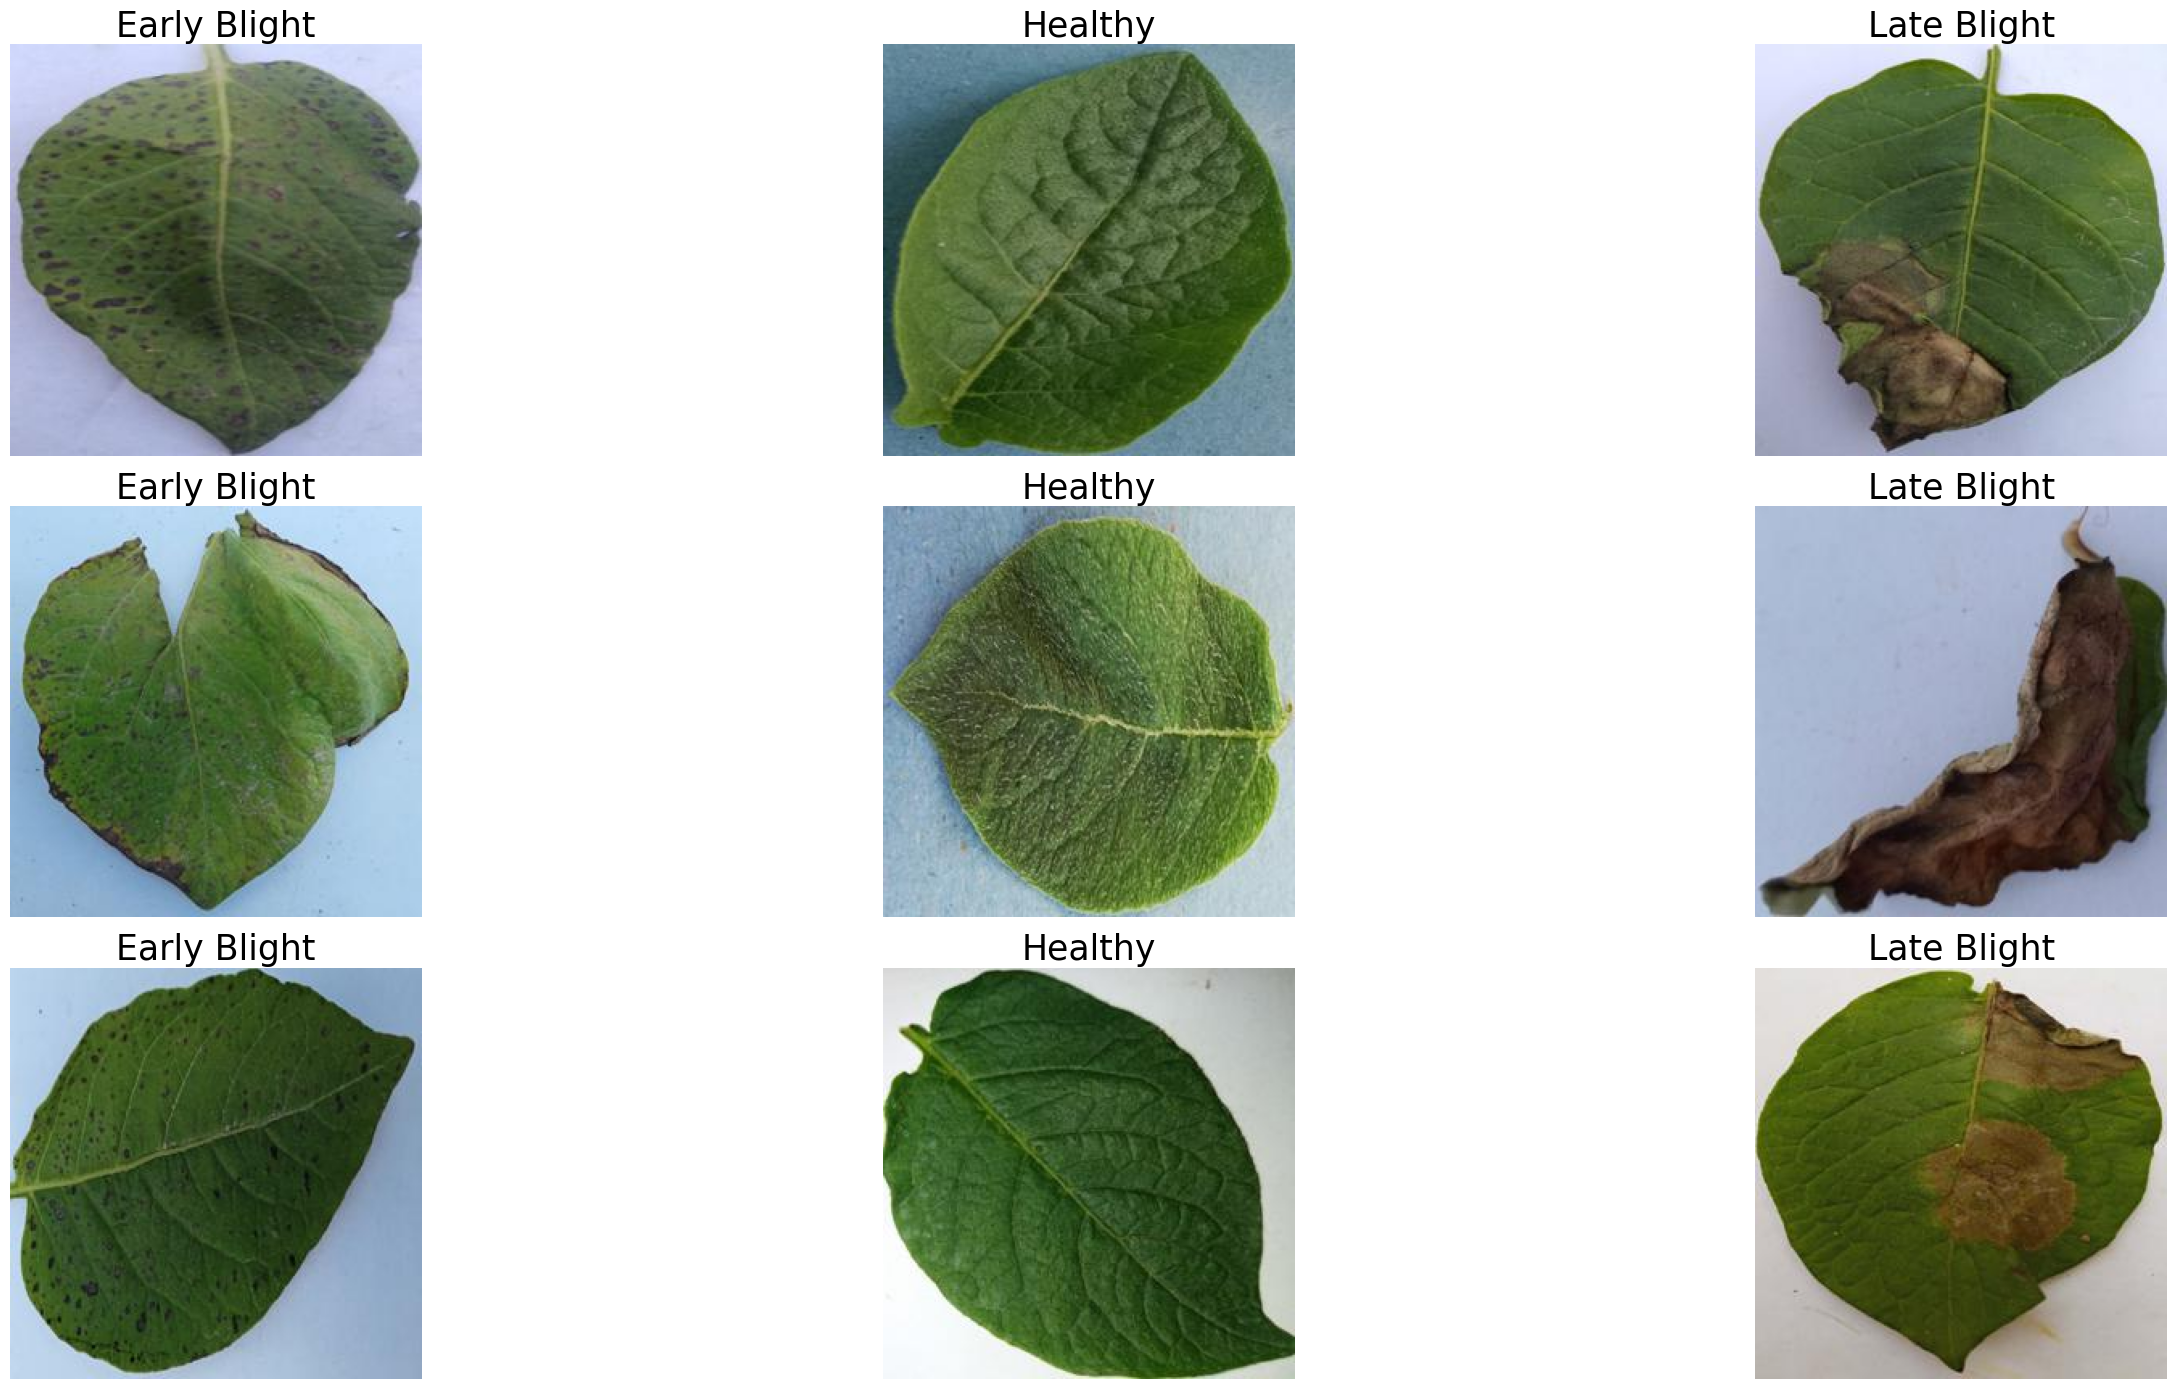

In [2]:
Early_Blight_path = 'PLD_3_Classes_256/Training/Early_Blight'
Healthy_path = 'PLD_3_Classes_256/Training/Healthy'
Late_Blight = 'PLD_3_Classes_256/Training/Late_Blight'

image_files = [os.path.join(Early_Blight_path, filename) for filename in os.listdir(Early_Blight_path)]
image_files2 = [os.path.join(Healthy_path, filename) for filename in os.listdir(Healthy_path)]
image_files3 = [os.path.join(Late_Blight, filename) for filename in os.listdir(Late_Blight)]

num_samples = 3

selected_images = random.sample(image_files, num_samples)
selected_images2 = random.sample(image_files2, num_samples)
selected_images3 = random.sample(image_files3, num_samples)

fig, axes = plt.subplots(3, num_samples, figsize=(30,14))

# Early Blight images
for i, image_path in enumerate(selected_images):
    ax = axes[i, 0]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Early Blight', fontsize=25)
    ax.axis('off')

# Healthy images
for i, image_path in enumerate(selected_images2):
    ax = axes[i, 1]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Healthy', fontsize=25)
    ax.axis('off')

# Late Blight images
for i, image_path in enumerate(selected_images3):
    ax = axes[i, 2]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Late Blight', fontsize=25)
    ax.axis('off')

plt.tight_layout()
plt.show()

# `Folders paths`

In [3]:
Early_Blight_path = 'PLD_3_Classes_256/Training/Early_Blight'
Healthy_path = 'PLD_3_Classes_256/Training/Healthy'
Late_Blight_path = 'PLD_3_Classes_256/Training/Late_Blight'

Val_Early_Blight_path = 'PLD_3_Classes_256/Validation/Early_Blight'
Val_Healthy_path = 'PLD_3_Classes_256/Validation/Healthy'
Val_Late_Blight_path = 'PLD_3_Classes_256/Validation/Late_Blight'

Test_Early_Blight_path = 'PLD_3_Classes_256/Testing/Early_Blight'
Test_Healthy_path = 'PLD_3_Classes_256/Testing/Healthy'
Test_Late_Blight_path = 'PLD_3_Classes_256/Testing/Late_Blight'

# Function to load and process images from a folder

In [4]:
def load_images(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        image_path = os.path.join(folder, filename)
        if image_path.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):  # Ensure it's an image
            image = Image.open(image_path)
            image = image.resize((128, 128))
            image = np.array(image) / 255.0
            images.append(image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Loading Train , Validation & Test images

In [5]:
train_early_images, train_early_labels = load_images(Early_Blight_path, 0)
train_healthy_images, train_healthy_labels = load_images(Healthy_path, 1)
train_late_images, train_late_labels = load_images(Late_Blight_path, 2)

val_early_images, val_early_labels = load_images(Val_Early_Blight_path, 0)
val_healthy_images, val_healthy_labels = load_images(Val_Healthy_path, 1)
val_late_images, val_late_labels = load_images(Val_Late_Blight_path, 2)

test_early_images, test_early_labels = load_images(Test_Early_Blight_path, 0)
test_healthy_images, test_healthy_labels = load_images(Test_Healthy_path, 1)
test_late_images, test_late_labels = load_images(Test_Late_Blight_path, 2)

# Combining images and labels of each dataset

In [6]:
train_images = np.concatenate((train_early_images, train_healthy_images, train_late_images), axis=0)
train_labels = np.concatenate((train_early_labels, train_healthy_labels, train_late_labels), axis=0)

# Shuffle
indices = np.arange(len(train_images))
np.random.shuffle(indices)
train_images = train_images[indices]
train_labels = train_labels[indices]

val_images = np.concatenate((val_early_images, val_healthy_images, val_late_images), axis=0)
val_labels = np.concatenate((val_early_labels, val_healthy_labels, val_late_labels), axis=0)

# Shuffle
indices = np.arange(len(val_images))
np.random.shuffle(indices)
val_images = val_images[indices]
val_labels = val_labels[indices]

test_images = np.concatenate((test_early_images, test_healthy_images, test_late_images), axis=0)
test_labels = np.concatenate((test_early_labels, test_healthy_labels, test_late_labels), axis=0)

# Shuffle
indices = np.arange(len(test_images))
np.random.shuffle(indices)
test_images = test_images[indices]
test_labels = test_labels[indices]

In [7]:
print(train_images.shape , train_labels.shape)
print(val_images.shape, val_labels.shape)
print(test_images.shape , test_labels.shape)

(3251, 128, 128, 3) (3251,)
(416, 128, 128, 3) (416,)
(405, 128, 128, 3) (405,)


In [8]:
Batch_size = 32
Epochs = 10
Seed = 88

In [9]:
# Ensure the images are in float32 format and labels are in int32 format
train_images = train_images.astype('float32')
val_images = val_images.astype('float32')
test_images = test_images.astype('float32')

train_labels = train_labels.astype('int32')
val_labels = val_labels.astype('int32')
test_labels = test_labels.astype('int32')

# Convert to TensorFlow datasets for easy CNN training
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(Batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(Batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(Batch_size).prefetch(tf.data.AUTOTUNE)


In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Data Augmentation block

In [22]:

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# **Modelling**

------------------------------------------------------------------------
# **Trial  1**

In [11]:
model = Sequential()
model.add(Input(shape=(128, 128, 3)))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,587 (76.51 KB)

 Trainable params: 19,587 (76.51 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, epochs=Epochs, batch_size=Batch_size, validation_data=val_dataset, shuffle=True , callbacks=[early_stopping])

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.4155 - loss: 1.0740 - val_accuracy: 0.4183 - val_loss: 1.0417
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4688 - loss: 1.0267 - val_accuracy: 0.4880 - val_loss: 1.0079
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5318 - loss: 0.9868 - val_accuracy: 0.5457 - val_loss: 0.9585
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5756 - loss: 0.9374 - val_accuracy: 0.5625 - val_loss: 0.9212
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6067 - loss: 0.8973 - val_accuracy: 0.5817 - val_loss: 0.8895
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6340 - loss: 0.8608 - val_accuracy: 0.5938 - val_loss: 0.8632
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6482 - loss: 0.8293 - val_accuracy: 0.6130 - val_loss: 0.8405
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6619 - loss: 0.7974 - val_accu

In [18]:
train_loss , train_acc = model.evaluate(train_dataset)
val_loss , val_acc = model.evaluate(val_dataset)
test_loss , test_acc = model.evaluate(test_dataset)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6753 - loss: 0.7380
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6492 - loss: 0.7528
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6713 - loss: 0.7411
Train Loss: 0.7357, Train Accuracy: 0.6693
Validation Loss: 0.7677, Validation Accuracy: 0.6490
Test Loss: 0.7379, Test Accuracy: 0.6593


------------------------------------------------------------------------
# **Trial  2**

In [13]:
model1 = Sequential()
model1.add(Input(shape=(128, 128, 3)))
model1.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model1.add(MaxPool2D((2, 2)))
model1.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model1.add(MaxPool2D((2, 2)))
model1.add(GlobalAveragePooling2D())
model1.add(Dense(64, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))
model1.add(Dense(3, activation='softmax'))

model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,003 (93.76 KB)

 Trainable params: 23,875 (93.26 KB)

 Non-trainable params: 128 (512.00 B)

In [14]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history1 = model1.fit(train_dataset, epochs=Epochs, batch_size=Batch_size, validation_data=val_dataset, shuffle=True , callbacks=[early_stopping])

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.5077 - loss: 1.0117 - val_accuracy: 0.3918 - val_loss: 1.0767
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6607 - loss: 0.8198 - val_accuracy: 0.3678 - val_loss: 1.0445
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7119 - loss: 0.7036 - val_accuracy: 0.4255 - val_loss: 1.0058
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7490 - loss: 0.6540 - val_accuracy: 0.7452 - val_loss: 0.8556
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7708 - loss: 0.5863 - val_accuracy: 0.7139 - val_loss: 0.7608
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7753 - loss: 0.5661 - val_accuracy: 0.7284 - val_loss: 0.6970
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7888 - loss: 0.5283 - val_accuracy: 0.8053 - val_loss: 0.5208
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8370 - loss: 0.4596 - val_accu

In [19]:
train_loss , train_acc = model1.evaluate(train_dataset)
val_loss , val_acc = model1.evaluate(val_dataset)
test_loss , test_acc = model1.evaluate(test_dataset)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8643 - loss: 0.3815
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8541 - loss: 0.3842
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8367 - loss: 0.4489
Train Loss: 0.3805, Train Accuracy: 0.8647
Validation Loss: 0.4265, Validation Accuracy: 0.8438
Test Loss: 0.4197, Test Accuracy: 0.8395


------------------------------------------------------------------------
# **Trial  3**

In [15]:
model2 = Sequential()
model2.add(Input(shape=(128, 128, 3)))
model2.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model2.add(MaxPool2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.3))
model2.add(Dense(3, activation='softmax'))

model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,494,403 (9.52 MB)

 Trainable params: 2,494,275 (9.51 MB)

 Non-trainable params: 128 (512.00 B)

In [16]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history2 = model2.fit(train_dataset, epochs=Epochs, batch_size=Batch_size, validation_data=val_dataset, shuffle=True , callbacks=[early_stopping])


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.5209 - loss: 0.9960 - val_accuracy: 0.3630 - val_loss: 4.3795
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6741 - loss: 0.7347 - val_accuracy: 0.3630 - val_loss: 2.8697
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7606 - loss: 0.6118 - val_accuracy: 0.3918 - val_loss: 2.6071
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8227 - loss: 0.4589 - val_accuracy: 0.7692 - val_loss: 0.5972
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8713 - loss: 0.3471 - val_accuracy: 0.6418 - val_loss: 1.4335
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8949 - loss: 0.2926 - val_accuracy: 0.6731 - val_loss: 0.8413
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9096 - loss: 0.2454 - val_accuracy: 0.6971 - val_loss: 1.4404
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9191 - loss: 0.2184 - val_acc

In [20]:
train_loss , train_acc = model2.evaluate(train_dataset)
val_loss , val_acc = model2.evaluate(val_dataset)
test_loss , test_acc = model2.evaluate(test_dataset)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7893 - loss: 0.5320
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7760 - loss: 0.5736
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7330 - loss: 0.6576
Train Loss: 0.5185, Train Accuracy: 0.7954
Validation Loss: 0.5972, Validation Accuracy: 0.7692
Test Loss: 0.5966, Test Accuracy: 0.7605


------------------------------------------------------------------------
# **Trial  4**

In [23]:
model3 = Sequential()
model3.add(Input(shape=(128, 128, 3)))
model3.add(data_augmentation)
model3.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model3.add(MaxPool2D((2, 2)))
model3.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model3.add(MaxPool2D((2, 2)))
model3.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model3.add(MaxPool2D((2, 2)))
model3.add(GlobalAveragePooling2D())
model3.add(Dense(64))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.3))
model3.add(Dense(3, activation='softmax'))

model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,955 (398.26 KB)

 Trainable params: 101,827 (397.76 KB)

 Non-trainable params: 128 (512.00 B)

In [24]:
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history3 = model3.fit(train_dataset, epochs=50, batch_size=Batch_size, validation_data=val_dataset, shuffle=True , callbacks=[early_stopping])

Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5234 - loss: 0.9904 - val_accuracy: 0.5000 - val_loss: 1.0678
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6716 - loss: 0.7653 - val_accuracy: 0.6346 - val_loss: 0.9748
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7568 - loss: 0.6007 - val_accuracy: 0.5337 - val_loss: 0.9445
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8038 - loss: 0.4997 - val_accuracy: 0.6707 - val_loss: 0.7725
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8221 - loss: 0.4570 - val_accuracy: 0.7740 - val_loss: 0.5834
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8346 - loss: 0.4423 - val_accuracy: 0.8413 - val_loss: 0.4705
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8569 - loss: 0.3691 - val_accuracy: 0.7716 - val_loss: 0.5191
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8578 - loss: 0.3700 - val_accu

In [25]:
train_loss , train_acc = model3.evaluate(train_dataset)
val_loss , val_acc = model3.evaluate(val_dataset)
test_loss , test_acc = model3.evaluate(test_dataset)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8869 - loss: 0.3091
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8959 - loss: 0.3160
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8445 - loss: 0.3987
Train Loss: 0.3065, Train Accuracy: 0.8896
Validation Loss: 0.3283, Validation Accuracy: 0.8822
Test Loss: 0.3775, Test Accuracy: 0.8494


------------------------------------------------------------------------
# **ResNet50** pre-trained model

In [27]:
resnet_model = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
for layer in resnet_model.layers:
    layer.trainable = False


In [29]:
resmodel = Sequential()
resmodel.add(Input(shape=(128, 128, 3)))
resmodel.add(data_augmentation)
resmodel.add(resnet_model)
resmodel.add(Flatten())
resmodel.add(Dense(64))
resmodel.add(BatchNormalization())
resmodel.add(Activation('relu'))
resmodel.add(Dropout(0.3))
resmodel.add(Dense(3, activation='softmax'))

resmodel.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,685,379 (97.98 MB)

 Trainable params: 2,097,539 (8.00 MB)

 Non-trainable params: 23,587,840 (89.98 MB)

In [30]:
resmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history4 = resmodel.fit(train_dataset, epochs=15, batch_size=Batch_size, validation_data=val_dataset, shuffle=True , callbacks=[early_stopping])

Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.5571 - loss: 1.0390 - val_accuracy: 0.3918 - val_loss: 3.0368
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.6390 - loss: 0.8573 - val_accuracy: 0.3918 - val_loss: 4.4079
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6638 - loss: 0.7891 - val_accuracy: 0.3918 - val_loss: 4.3396
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.6788 - loss: 0.7787 - val_accuracy: 0.3918 - val_loss: 4.3484
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.6937 - loss: 0.7280 - val_accuracy: 0.3942 - val_loss: 3.3294
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.6927 - loss: 0.7271 - val_accuracy: 0.4207 - val_loss: 3.0021
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.6897 - loss: 0.7058 - val_accuracy: 0.4736 - val_loss: 1.5675
Epoch 8/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6891 - loss: 0.7056 - val

In [31]:
train_loss , train_acc = resmodel.evaluate(train_dataset)
val_loss , val_acc = resmodel.evaluate(val_dataset)
test_loss , test_acc = resmodel.evaluate(test_dataset)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7422 - loss: 0.6028
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7086 - loss: 0.7133
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7156 - loss: 0.6839
Train Loss: 0.6158, Train Accuracy: 0.7401
Validation Loss: 0.7124, Validation Accuracy: 0.7043
Test Loss: 0.6638, Test Accuracy: 0.7259


------------------------------------------------------------------------
# **VGG** pre-trained model

## `Trial 1`

In [32]:
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
for layer in vgg_model.layers:
  layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [33]:
vggmodel = Sequential()
vggmodel.add(Input(shape=(128, 128, 3)))
vggmodel.add(data_augmentation)
vggmodel.add(vgg_model)
vggmodel.add(Flatten())
vggmodel.add(Dense(64))
vggmodel.add(BatchNormalization())
vggmodel.add(Activation('relu'))
vggmodel.add(Dropout(0.3))
vggmodel.add(Dense(3, activation='softmax'))

vggmodel.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,239,491 (58.13 MB)

 Trainable params: 524,675 (2.00 MB)

 Non-trainable params: 14,714,816 (56.13 MB)

In [34]:
vggmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history5 = vggmodel.fit(train_dataset, epochs=50, batch_size=Batch_size, validation_data=val_dataset, shuffle=True , callbacks=[early_stopping])

Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.6359 - loss: 0.9128 - val_accuracy: 0.5505 - val_loss: 1.4774
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.8066 - loss: 0.4721 - val_accuracy: 0.6659 - val_loss: 1.0897
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8530 - loss: 0.3937 - val_accuracy: 0.7596 - val_loss: 0.6762
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8497 - loss: 0.3824 - val_accuracy: 0.7284 - val_loss: 0.8390
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8800 - loss: 0.3392 - val_accuracy: 0.8558 - val_loss: 0.3599
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8850 - loss: 0.3169 - val_accuracy: 0.8486 - val_loss: 0.3717
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8719 - loss: 0.3304 - val_accuracy: 0.8702 - val_loss: 0.3671
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8873 - loss: 0.3024 - val_acc

In [35]:
train_loss , train_acc = vggmodel.evaluate(train_dataset)
val_loss , val_acc = vggmodel.evaluate(val_dataset)
test_loss , test_acc = vggmodel.evaluate(test_dataset)
print(f"Train Loss: {train_loss:.4f},   Train Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f},   Validation Accuracy: {val_acc:.4f}")
print(f"Test Loss: {test_loss:.4f},   Test Accuracy: {test_acc:.4f}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9412 - loss: 0.1680
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8642 - loss: 0.3335
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9313 - loss: 0.2087
Train Loss: 0.1645,   Train Accuracy: 0.9452
Validation Loss: 0.2930,   Validation Accuracy: 0.8798
Test Loss: 0.2442,   Test Accuracy: 0.9185


## `Trial 2`  

In [38]:
vgg_model2 = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
for layer in vgg_model2.layers[:-4]:  # Freeze the first (12) layers
    layer.trainable = False
for layer in vgg_model2.layers[-4:]:  # Unfreeze the last 4 layers
    layer.trainable = True

In [40]:
vggmodel2 = Sequential()
vggmodel2.add(Input(shape=(128, 128, 3)))
vggmodel2.add(data_augmentation)
vggmodel2.add(vgg_model2)
vggmodel2.add(Flatten())
vggmodel2.add(Dropout(0.3))
vggmodel2.add(Dense(64))
vggmodel2.add(BatchNormalization())
vggmodel2.add(Activation('relu'))
vggmodel2.add(Dropout(0.3))
vggmodel2.add(Dense(3, activation='softmax'))

vggmodel2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,239,491 (58.13 MB)

 Trainable params: 7,604,099 (29.01 MB)

 Non-trainable params: 7,635,392 (29.13 MB)

In [41]:
vggmodel2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history6 = vggmodel2.fit(train_dataset, epochs=50, batch_size=Batch_size, validation_data=val_dataset, shuffle=True , callbacks=[early_stopping])

Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.6233 - loss: 0.8614 - val_accuracy: 0.6755 - val_loss: 2.7188
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8680 - loss: 0.3363 - val_accuracy: 0.6611 - val_loss: 1.4760
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8992 - loss: 0.2715 - val_accuracy: 0.6538 - val_loss: 1.7097
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9007 - loss: 0.2593 - val_accuracy: 0.7812 - val_loss: 0.6810
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9059 - loss: 0.2343 - val_accuracy: 0.6971 - val_loss: 1.1503
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9228 - loss: 0.2031 - val_accuracy: 0.8582 - val_loss: 0.4140
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9236 - loss: 0.2010 - val_accuracy: 0.6226 - val_loss: 1.9007
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9265 - loss: 0.1994 - val_a

In [42]:
train_loss , train_acc = vggmodel2.evaluate(train_dataset)
val_loss , val_acc = vggmodel2.evaluate(val_dataset)
test_loss , test_acc = vggmodel2.evaluate(test_dataset)
print(f"Train Loss: {train_loss:.4f},   Train Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f},   Validation Accuracy: {val_acc:.4f}")
print(f"Test Loss: {test_loss:.4f},   Test Accuracy: {test_acc:.4f}")

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9606 - loss: 0.1103
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9194 - loss: 0.1753
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9572 - loss: 0.1157
Train Loss: 0.1101,   Train Accuracy: 0.9603
Validation Loss: 0.1873,   Validation Accuracy: 0.9255
Test Loss: 0.1618,   Test Accuracy: 0.9383


## `Trial 3`  -->  `Highest Accuracy`

In [53]:
vgg_model4 = VGG16(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
for layer in vgg_model4.layers[:-4]:  # Freeze the first layers
    layer.trainable = False
for layer in vgg_model4.layers[-4:]:  # Unfreeze the last layers
    layer.trainable = True

In [54]:
vggmodel4 = Sequential()
vggmodel4.add(Input(shape=(128, 128, 3)))
vggmodel4.add(data_augmentation)
vggmodel4.add(vgg_model4)
vggmodel4.add(Flatten())
vggmodel4.add(Dropout(0.3))
vggmodel4.add(Dense(64))
vggmodel4.add(BatchNormalization())
vggmodel4.add(Activation('relu'))
vggmodel4.add(Dropout(0.3))
vggmodel4.add(Dense(3, activation='softmax'))

vggmodel4.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_104         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_102 (Activation)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,239,491 (58.13 MB)

 Trainable params: 7,604,099 (29.01 MB)

 Non-trainable params: 7,635,392 (29.13 MB)

In [55]:
vggmodel4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history6 = vggmodel4.fit(train_dataset, epochs=50, batch_size=Batch_size, validation_data=val_dataset, shuffle=True , callbacks=[early_stopping])

Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.5970 - loss: 0.9454 - val_accuracy: 0.6298 - val_loss: 2.2592
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.8523 - loss: 0.3751 - val_accuracy: 0.6322 - val_loss: 1.4519
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8998 - loss: 0.2578 - val_accuracy: 0.4279 - val_loss: 3.8208
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9111 - loss: 0.2465 - val_accuracy: 0.8293 - val_loss: 0.4541
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.8956 - loss: 0.2458 - val_accuracy: 0.8846 - val_loss: 0.3109
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9228 - loss: 0.2138 - val_accuracy: 0.8774 - val_loss: 0.3016
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.9258 - loss: 0.2009 - val_accuracy: 0.8293 - val_loss: 0.5907
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9252 - loss: 0.2025 - val

In [56]:
train_loss , train_acc = vggmodel4.evaluate(train_dataset)
val_loss , val_acc = vggmodel4.evaluate(val_dataset)
print(f"Train Loss: {train_loss:.4f},   Train Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f},   Validation Accuracy: {val_acc:.4f}")


102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9721 - loss: 0.0782
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9349 - loss: 0.1958
Train Loss: 0.0819,   Train Accuracy: 0.9708
Validation Loss: 0.1911,   Validation Accuracy: 0.9351


------------------------------------------------------------------------
# **IncepttionV3** pre-trained model

In [44]:
inc_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
for layer in inc_model.layers:
    layer.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [45]:
incmodel = Sequential()
incmodel.add(Input(shape=(128, 128, 3)))
incmodel.add(data_augmentation)
incmodel.add(inc_model)
incmodel.add(Flatten())
incmodel.add(Dense(64))
incmodel.add(BatchNormalization())
incmodel.add(Activation('relu'))
incmodel.add(Dropout(0.3))
incmodel.add(Dense(3, activation='softmax'))

incmodel.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_102         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_100 (Activation)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,327,587 (85.17 MB)

 Trainable params: 524,675 (2.00 MB)

 Non-trainable params: 21,802,912 (83.17 MB)

In [46]:
incmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history7 = incmodel.fit(train_dataset, epochs=50, batch_size=Batch_size, validation_data=val_dataset, shuffle=True , callbacks=[early_stopping])

Epoch 1/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.7397 - loss: 0.6086 - val_accuracy: 0.8365 - val_loss: 0.3926
Epoch 2/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8583 - loss: 0.3559 - val_accuracy: 0.8726 - val_loss: 0.3243
Epoch 3/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8745 - loss: 0.3253 - val_accuracy: 0.8630 - val_loss: 0.3206
Epoch 4/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8782 - loss: 0.3242 - val_accuracy: 0.7692 - val_loss: 0.4981
Epoch 5/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8823 - loss: 0.3049 - val_accuracy: 0.8822 - val_loss: 0.2860
Epoch 6/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8754 - loss: 0.3104 - val_accuracy: 0.8630 - val_loss: 0.3274
Epoch 7/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8898 - loss: 0.2953 - val_accuracy: 0.8774 - val_loss: 0.2979
Epoch 8/50
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9006 - loss: 0.2651 - val_acc

In [48]:
train_loss , train_acc = incmodel.evaluate(train_dataset)
val_loss , val_acc = incmodel.evaluate(val_dataset)
test_loss , test_acc = incmodel.evaluate(test_dataset)
print(f"Train Loss: {train_loss:.4f},   Train Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f},   Validation Accuracy: {val_acc:.4f}")
print(f"Test Loss: {test_loss:.4f},   Test Accuracy: {test_acc:.4f}")


102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9150 - loss: 0.2151
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8915 - loss: 0.2595
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8795 - loss: 0.2667
Train Loss: 0.2210,   Train Accuracy: 0.9133
Validation Loss: 0.2860,   Validation Accuracy: 0.8822
Test Loss: 0.2635,   Test Accuracy: 0.8840


------------------------------------------------------------------------
# **Visualization for our Model Predictions**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


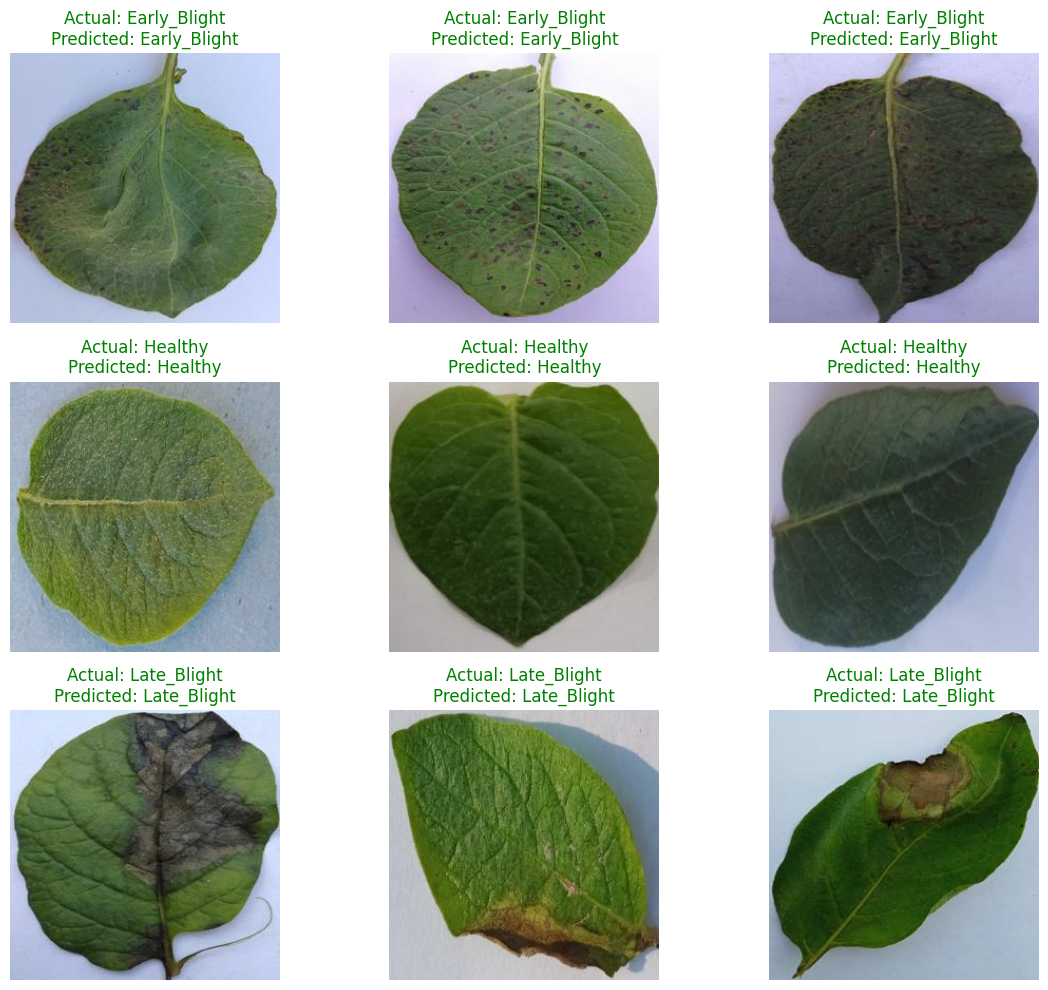

In [57]:
from tensorflow.keras.preprocessing import image

model = vggmodel4
dataset_path = "/content/PLD_3_Classes_256/Testing"
class_labels = ["Early_Blight", "Healthy", "Late_Blight"]

# Check if directories exist
for class_name in class_labels:
    class_dir = os.path.join(dataset_path, class_name)
    if not os.path.exists(class_dir):
        raise FileNotFoundError(f"Error: Directory '{class_dir}' does not exist!")

def preprocess_image(image_path, target_size=(128, 128)):
    try:
        img = image.load_img(image_path, target_size=target_size)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        return img_array
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None


def predict_image(image_path):
    img_array = preprocess_image(image_path)
    if img_array is None:
        return "Unreadable"

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    return class_labels[predicted_class]


selected_images = []
actual_labels = []

for class_name in class_labels:
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]
    selected_images.extend(random.sample(images, 3))  # Select exactly 3 images per class
    actual_labels.extend([class_name] * 3)  # Add corresponding labels

plt.figure(figsize=(12, 10))

for i, img_path in enumerate(selected_images):
    predicted_label = predict_image(img_path)

    try:
        img = image.load_img(img_path)
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        title_color = 'green' if predicted_label == actual_labels[i] else 'red'
        plt.title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_label}", color=title_color)
    except Exception as e:
        print(f"Error displaying image {img_path}: {e}")

plt.tight_layout()
plt.show()
